# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [58]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [59]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [60]:
df.count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

**c.** The number of unique users in the dataset.

In [61]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [62]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [63]:
df.query("group == 'treatment' and landing_page != 'new_page'").count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [64]:
df.query("group == 'control' and landing_page == 'new_page'").count()

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64

**f.** Do any of the rows have missing values?

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [66]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
treatment_old = df.query("group == 'treatment' and landing_page != 'new_page'")
control_new = df.query("group == 'control' and landing_page == 'new_page'")

inaccurate_rows = treatment_old.append(control_new)

df2 = df[~df.isin(inaccurate_rows)].dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null float64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null float64
dtypes: float64(2), object(3)
memory usage: 13.3+ MB


In [67]:
# Double check if all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [68]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [69]:
duplicated_rows = df2[df2.user_id.duplicated()]

**c.** Display the rows for the duplicate **user_id**? 

In [70]:
duplicated_rows

,user_id,timestamp,group,landing_page,converted
2893,773192.0,2017-01-14 02:55:59.590927,treatment,new_page,0.0


In [71]:
#Show both rows
df2.query("user_id == '773192.0'")

,user_id,timestamp,group,landing_page,converted
1899,773192.0,2017-01-09 05:37:58.781806,treatment,new_page,0.0
2893,773192.0,2017-01-14 02:55:59.590927,treatment,new_page,0.0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [72]:
# Remove one of the rows with a duplicate user_id..
df2 = df2.drop(2893)
# Check again if the row with a duplicate user_id is deleted or not
df2.query("user_id == '773192.0'")

,user_id,timestamp,group,landing_page,converted
1899,773192.0,2017-01-09 05:37:58.781806,treatment,new_page,0.0


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>




In [73]:
p_population = df2.query("converted == '1.0'").user_id.nunique()/df2.user_id.nunique()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [74]:
p_control = df2.query("converted == '1.0' and group == 'control'").count()/df2.query("group == 'control'").count()
p_control[4]

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [75]:
p_treatment = df2.query("converted == '1.0' and group == 'treatment'").count()/df2.query("group == 'treatment'").count()
p_treatment[4]

0.11880806551510564

In [76]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
obs_diff = obs_diff[4]
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [77]:
new_page = df2.query("landing_page == 'new_page' ").count()/df2.count()
new_page[4]

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.


Given the computed results, it looks like the conversion rate of the treatment group is slightly below the conversion rate of the control group. While the control group has a conversion rate of 12.04%, the treatment group has a conversion rate of 11.88%. The difference between both conversion rates is minimal, lying at - 0.16 percent points. Given also the fact that the probability of receiving a new page or an old page is nearly 50% for both cases, is shows that the new page does even convert worse than the old page.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Put your answer here.**

**$H_0$**: **$p_{new}$** - **$p_{old}$** $\leq$ 0

**$H_1$**: **$p_{new}$** - **$p_{old}$** > 0 

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [78]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [79]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br>

In [80]:
n_new = df2.landing_page.value_counts()[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [81]:
n_old = df2.landing_page.value_counts()[1]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [82]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size=n_new, p=[p_new, 1-p_new])
p_converted_new = new_page_converted.mean()
p_converted_new

0.88046934140802424

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [83]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], size=n_old, p=[p_old, 1-p_old])
p_converted_old = old_page_converted.mean()
p_converted_old

0.88034335118465801

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [84]:
converted_probability = p_converted_new - p_converted_old
converted_probability

0.00012599022336623467


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [85]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    old_page_converted = np.random.choice([0,1], size=n_old, p=[p_old, 1-p_old]).mean()
    new_page_converted = np.random.choice([0,1], size=n_old, p=[p_new, 1-p_new]).mean()
    converted_probability = new_page_converted - old_page_converted
    p_diffs.append(converted_probability)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

Text(0,0.5,'Number of conversions')

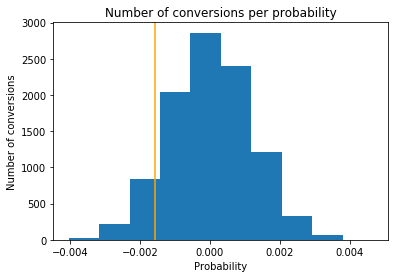

In [86]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color = "orange")
plt.title("Number of conversions per probability")
plt.xlabel("Probability")
plt.ylabel("Number of conversions")

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [87]:
# Compute proportion
(p_diffs>obs_diff).mean()

0.90969999999999995

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

I computed the Statistical Significance with a p-value of 0.907. The number shows that it seems very likely that our statistic is from the null. Considering given eror rates, we would fail to reject H0 in case the computed p-value is bigger than the Type-I error rate.

As the p-value is bigger than the given Type I error rate with 0.907 > 0.05 we fail to reject H0 and should keep the old page.




**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [88]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("converted == '1.0' and group == 'control'").count()[4]

# number of conversions with the new_page
convert_new = df2.query("converted == '1.0' and group == 'treatment'").count()[4]

# number of individuals who were shown the old_page
n_old = df2.query("group == 'control'").count()[4]

# number of individuals who received new_page
n_new = df2.query("group == 'treatment'").count()[4]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

In [89]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

As I defined H1 as **$p_{new}$** - **$p_{old}$** > 0, the test was right-tailed. According to this we should reject null if $Z_{score}$ > $Z_{\alpha}$ . The $Z_{score}$ with -1.311 is smaller than $Z_{\alpha}$ with 1.645 and therefore we fail to reject null. The p-value with 0.905 is almost the same as the p-value computed before. The newly computed values of z_score and p-value show the same outcome as the results computed in **j.** and **k.**, that we fail to reject null and should keep the old page.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

We should use a Logistic Regression as it predicts a categorical response when there is only two outcomes like "conversion" or "no conversion".

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [90]:
# Create column "intersept"
df2['intersept'] = 1

In [91]:
# Create column "ab_page"
df2['ab_page'] = np.where(df2['group']=='treatment',1,0)

In [92]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intersept,ab_page
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [93]:
# Instantiate logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intersept','ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [94]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-25 17:38 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intersept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

The p-value associated with ab_page is 0.1899. It differs from the p-value from Part II as we look at two different hypotheses tested. The hypothesis testing in this part performs a two-sided test while in Part II we performed a one-sided (right-tailed) test.

As the p-value is higher than the error rate with 0.1899 > 0.05 we can fail to reject H0 and should keep the old page.

A standard linear regression test like this goes with the H0 as β1 = 0 and H1 as β1 ≠ 0 
This means that H0 would be that the new page having no influence on the conversion rate while H1 will be the new page having an impact on the conversion rate.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There could be many factors that could influence the behaviour of the individuals converting. A conversion is supposed to convert a user on the page into a user buying the company's product. A factor for not converting could be missing variation on payment methods not containing the favorite method for a user. Also we don't know if some users in the test group are color blind and may perceive certain things differently than non-color blind participants. Furthermore the time spent per session could be of interest and relevant for further findings.
Additionaly the Novelty effect or change aversion can play a part in influencing the users behaviour as well.

Every additional term added to the regression model is adding to the complexity of the model but could also improve the model. But the disadvantage is that adding more terms can also lead to multicollinearity in case multiple variables are correlated with each other. This will lead to less reliable probabilities. Furthermore it can happen that there is simply no linear relationship between the added variable and the value we are investigating as response.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [95]:
# Read the countries.csv
countries = pd.read_csv("countries.csv")

In [96]:
# Join with the df2 dataframe
df_merged = pd.merge(df2, countries, on='user_id', how='inner')
df_merged.head(10)

,user_id,timestamp,group,landing_page,converted,intersept,ab_page,country
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,US
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1,US
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0,US
5,936923.0,2017-01-10 15:20:49.083499,control,old_page,0.0,1,0,US
6,679687.0,2017-01-19 03:26:46.940749,treatment,new_page,1.0,1,1,CA
7,719014.0,2017-01-17 01:48:29.539573,control,old_page,0.0,1,0,US
8,817355.0,2017-01-04 17:58:08.979471,treatment,new_page,1.0,1,1,UK
9,839785.0,2017-01-15 18:11:06.610965,treatment,new_page,1.0,1,1,CA


In [97]:
# Create the necessary dummy variables
df_merged[['UK','US','CA']] = pd.get_dummies(df_merged['country'])

In [98]:
df_merged.head(10)

,user_id,timestamp,group,landing_page,converted,intersept,ab_page,country,UK,US,CA
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,US,0,0,1
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1,US,0,0,1
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0,US,0,0,1
5,936923.0,2017-01-10 15:20:49.083499,control,old_page,0.0,1,0,US,0,0,1
6,679687.0,2017-01-19 03:26:46.940749,treatment,new_page,1.0,1,1,CA,1,0,0
7,719014.0,2017-01-17 01:48:29.539573,control,old_page,0.0,1,0,US,0,0,1
8,817355.0,2017-01-04 17:58:08.979471,treatment,new_page,1.0,1,1,UK,0,1,0
9,839785.0,2017-01-15 18:11:06.610965,treatment,new_page,1.0,1,1,CA,1,0,0


In [99]:
# Compute model and dropping "CA"
lm=sm.Logit(df_merged['converted'], df_merged[['intersept','UK','US']])
results=lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-25 17:38 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intersept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
US            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

I now had a look solely if the country origin of the users is influencing the conversion. There is statistical evidence that the average conversion of users from UK doesn't differ from the average conversion of users from the US as the confidence intervals from UK and US overlap. Overall the countries don't have an impact on the conversion.

In [100]:
# Compute OLS model and with 'ab_page',UK','US' and dropping "CA"
lm=sm.Logit(df_merged['converted'], df_merged[['intersept','ab_page','UK','US']])
results=lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-25 17:38 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intersept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
US            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

The adding of the 'ab_page' variable doesn't change anything in the overall trend. All given p-values are, indivially looked at, higher than the error rate of 0.05. So all provide us data to fail to reject H0 and keep the old page.
The confidence intervall of all variables is overlapping, showing that there is statistical evidence that the average conversion in ab_page doesn't differ from the average conversion in variables UK and US.

The p-values show to which percentage one of the three variables is not affecting the 'converted' variable. So for 'ab_page' there is a 19.1% chance to not affect 'converted, while the chance for UK is near 13% and for US 45.7%. 

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results.

In [101]:
# Create new columns
new_UK = df_merged['ab_page'] * df_merged['UK']
new_US = df_merged['ab_page'] * df_merged['US']

# Add columns to df
df_merged['new_UK'] = new_UK
df_merged['new_US'] = new_US

df_merged.head(10)

,user_id,timestamp,group,landing_page,converted,intersept,ab_page,country,UK,US,CA,new_UK,new_US
0,851104.0,2017-01-21 22:11:48.556739,control,old_page,0.0,1,0,US,0,0,1,0,0
1,804228.0,2017-01-12 08:01:45.159739,control,old_page,0.0,1,0,US,0,0,1,0,0
2,661590.0,2017-01-11 16:55:06.154213,treatment,new_page,0.0,1,1,US,0,0,1,0,0
3,853541.0,2017-01-08 18:28:03.143765,treatment,new_page,0.0,1,1,US,0,0,1,0,0
4,864975.0,2017-01-21 01:52:26.210827,control,old_page,1.0,1,0,US,0,0,1,0,0
5,936923.0,2017-01-10 15:20:49.083499,control,old_page,0.0,1,0,US,0,0,1,0,0
6,679687.0,2017-01-19 03:26:46.940749,treatment,new_page,1.0,1,1,CA,1,0,0,1,0
7,719014.0,2017-01-17 01:48:29.539573,control,old_page,0.0,1,0,US,0,0,1,0,0
8,817355.0,2017-01-04 17:58:08.979471,treatment,new_page,1.0,1,1,UK,0,1,0,0,1
9,839785.0,2017-01-15 18:11:06.610965,treatment,new_page,1.0,1,1,CA,1,0,0,1,0


In [102]:
# Fit your model, and summarize the results
lm=sm.Logit(df_merged['converted'], df_merged[['intersept','ab_page','UK','US','new_UK','new_US']])
results=lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-12-25 17:38 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intersept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
new_UK       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
new_US        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

Smaller p-values suggest that the associated variables are statistically significant. But the results show all p-values with higher numbers and therefore showing their statistical insignificance.
To further interpret the results, I exponentiate the coefficients:

In [103]:
np.exp(-0.0206), np.exp(-0.0175), np.exp(-0.0057), np.exp(-0.0469), np.exp(0.0314) 

(0.97961073050325054,
 0.9826522356650732,
 0.99431621417843319,
 0.95418281110072622,
 1.0318981806179213)

As the results are below 1, I take the reciprocal:

In [104]:
1/np.exp(-0.0206), 1/np.exp(-0.0175), 1/np.exp(-0.0057), 1/np.exp(-0.0469), 1/np.exp(0.0314) 

(1.0208136445037459,
 1.0176540221507617,
 1.0057162759095335,
 1.0480172021191829,
 0.96908786039450134)

Even after exponentiating and taking the reciprocal, the coefficients continue showing the picture of the statistical insignificance of the variables. We have findings like that the conversion is 1.01 times higher when the user comes from the UK, holding all other variables constant. But this number and all other coefficient numbers that are similar to this value are too low to provide any significance.

As there is no statistical significance, we don't need to investigate for a practical significance.

Overall the adding of page and country didn't have any impact on predicting the conversion as the values added prove to be not significant for influencing the conversion.

As a final conclusion I still fail to reject the null hypotheses. We should keep the old page as there is no proof that the new page is leading to more conversions.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [105]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0